In [21]:
from __future__ import print_function
from IPython.display import Image
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.cluster as cluster
from sklearn.ensemble import RandomForestClassifier
from apyori import apriori
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
import glob
import os
import itertools
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Lab Three: Association Rule Mining, Clustering, or Collaborative Filtering
### Group A: Mai Loan Tran, Lei Jiang, Zackary Gill, & Samantha Sprague

## Table of Contents for Lab 3
* <a href="#Introduction">Introduction</a>
* <a href="#Business Understanding">Business Understanding</a>
* <a href="#Data Understanding">Data Understanding</a>
* <a href="#Modeling and Evaluation">Modeling and Evaluation</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional Work">Exceptional Work</a>
* <a href="#References">References</a>

<a id="Introduction"></a>
## Introduction

Diabetes is the leading cause of death in the world. Roughly 422 million people have diabetes. There are three major types of diabetes: type 1, type 2, and gestational diabetes. Type 2 is the most common type of diabetes, and is thought to be preventable! While the leading cause of death, with identification and proper management of diabetes most individuals can lead happy and healthy lives. The key to manageable diabetes is often early detection and proper treatment. 

This notebook will guide the reader through a comprehensive analysis that evaluates our ability to use unsupervised learning techniques to cluster our diabetes dataset to glean new information and previously unseen  patterns. 

Our dataset does not align patients to a specific type of diabetes. Our hypothesis for this task is that our data will naturally cluster itself to showcase the different types of diabetes: type 1, type 2, gesitational, pre-diabetes, and lastly no diabetes. 

Our findings in this report lead us not only to validate the hypothesis above, but provide even more insight into diabetes type with severity of diabetes. Read on for more information! 

<a id="Business Understanding"></a>
## Business Understanding

**Requirements**: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? 

The purpose of the data set we selected was intented to predict whether or not a patient with diabetes would be readmitted to the hospital. Because of the intent of the assignment, we chose to perform an unsupervised clustering analysis with the hypothesis that we could categorize these patients into clusters that align to their diabetes type. 

In order to measure the effectiveness of our clustering algorithm, we will primarly lean on external validation metrics like predictive strength and silhouette analysis. Predictive strength is a technique to validate cluster accuracy using a supervised learning technique to predict unsupervised clusters. In our analysis, we use a random forest technique to predict our clusters. The internal validation metrics we will use include Davies–Bouldin Index and the Calinski Harabaz score.

Predictive strength is an effective validation method as it helps check the quality of the clusters, in addition, can show the differences between a Gaussian clustering technique vs. KMeans. The silhouette analysis is an effective validation technique because it can determine if we are correctly classfying our clusters. If you see negative values in a silhouette analysis you can classifing incorrectly, and if you see positive values, you are classifying correctly. These external validation technique help us analyze across clusters.

<a id="Data Understanding"></a>
## Data Understanding

**Requirements**: Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

| Variable Name | Type |Definition |
|---------------|------|-----------|
| max_glu_serum | Categorical | Glucose serum test results |
| A1Cresult | Categorical |  A1C test results |
|gender| Binary | The gender of the patient: Male (0) or Female (1)  |
|diabetesMed| Binary |  Indicator of diabetes medications: No (0) or Yes (1) |
| age | Continous | Patient age |
| medication_count | Continous | Medication administered during visit |
| num_lab_procedures| Continous | Number of lab procuedures during visit|

Luckily our dataset for this analysis does not include any missing values or duplicate data. In addition, any outliers found in this data cannot be removed or disregarded as the data points cannot be verified to be an error in entry. Because of this, we must treat all data points as facts and leverage the insight they provide to us. 

**Requirements**: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

Below are the distributions of the variables leveraged in the analysis below. 

In [3]:
import pandas as pd
directory = '/Users/samanthasprague/Downloads/'
df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')

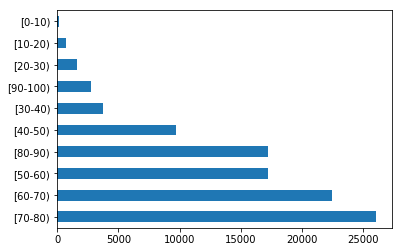

In [5]:
import matplotlib.pyplot as plt
df1 = df["age"].value_counts()
df1.plot(kind = 'barh')
plt.show()

There seems to be a skewed distribution of the age variable. Majority of the dataset seems to be skewed from the latter half of the age range of 50-90. This is important as the variable is skewed and will need to be normalized. 

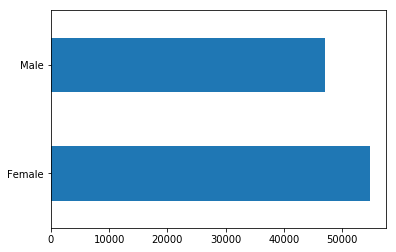

In [6]:
df2 = df["gender"].value_counts()
df2.plot(kind = 'barh')
plt.show()

There is a great even distribution of gender across the data set, especially given the large sample size. 

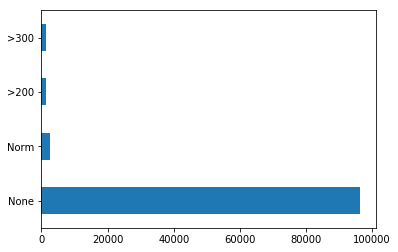

In [7]:
df3 = df["max_glu_serum"].value_counts()
df3.plot(kind = 'barh')
plt.show()

There is a very skewed distribution for the max_glu_serum. While this variable will need to be normalized the insights provided from the non-"None" values will be vital to the clusters. 

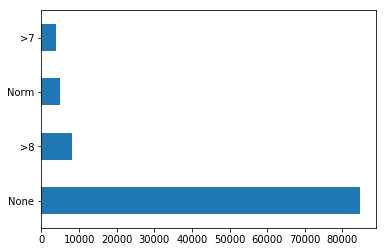

In [8]:
df4 = df["A1Cresult"].value_counts()
df4.plot(kind = 'barh')
plt.show()

In addition to the max_glu_serum, the A1C result definitely seems to follow the same skewed distribution. This will need to be normalized prior to modeling. 

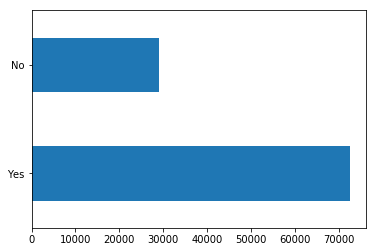

In [9]:
df5 = df["diabetesMed"].value_counts()
df5.plot(kind = 'barh')
plt.show()

The diabetes medication variable seems to only slight be skewed in this distribution. Oversampling may be a technique we need to employ if we do not end up seeing good separation with these skewed variables. 

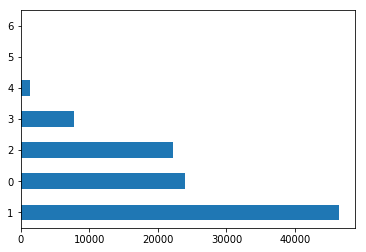

In [10]:
df6 = df["medication_count"].value_counts()
df6.plot(kind = 'barh')
plt.show()

The medication count variable is also skewed, but does provide good information. 

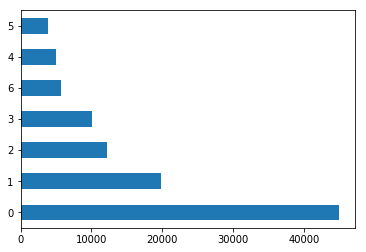

In [11]:
df3 = df["num_procedures"].value_counts()
df3.plot(kind = 'barh')
plt.show()

Another skewed chart for number of procedures, this skewness will likely heavily influence cluster size and accuracy. All skewed variables will be corrected with a normalization prior to clustering. Hopefully, this is enough to provide great results. If not, other techniques will need to be used in order to better provide insight. 

<a id="Modeling and Evaluation"></a>
## Modeling and Evaluation

Below is the necessary data preparation prior to modeling. 

#### Data Preperation 

In [51]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


In [52]:
df_zg_makehot = df_zg[["max_glu_serum", "A1Cresult", "insulin"]]
df_zg_ok = df_zg[["age", "gender", "diabetesMed"]]

In [53]:
#Make age ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ok.loc[df_zg_ok['age'] == val, 'age'] = i
df_zg_ok["age"] = df_zg_ok["age"].astype(int)
 
#Gender: 1 = Female, 0 = Male
df_zg_ok.gender[df_zg_ok.gender == 'Male'] = 0
df_zg_ok.gender[df_zg_ok.gender == 'Female'] = 1
df_zg_ok["gender"] = df_zg_ok["gender"].astype(object)

#diabetesMed: 1 = Yes, 0 = No
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'No'] = 0
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'Yes'] = 1
df_zg_ok["diabetesMed"] = df_zg_ok["diabetesMed"].astype(object)

In [54]:
df_zg_hot_x = pd.concat([df_zg_ok, pd.get_dummies(df_zg_makehot)], axis = 1)
df_zg_y = df_zg["readmitted_tf"]

In [55]:
x_train, x_test, y_train, y_test = train_test_split(df_zg_hot_x, df_zg_y, test_size = 0.8, random_state = 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_test.shape

((20353, 15), (81413, 15))

In [56]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

#### Train and adjust parameters
**Requirements**: Perform cluster analysis using several clustering methods (adjust parameters).
#### Evaluate and Compare
**Requirements**: Use internal and/or external validation measures to describe and compare the clusterings and the clusters— how did you determine a suitable number of clusters for each method?

The code necessary for the both of requirements above is below. We created an advanced function that performs both the training, hyper-parameter tuning, and evaluation. 

##### Clustering Functions

The following function is designed to train a clustering model, adjust the number of clusters, and evaluate the models based on the cluster size, using Davies Bouldin score, Calinski Harabasz score, a silhouette anaylysis, and predictive strength. We use a random forest algorithm for the predictive strength evlauation. These functions are used throughout our analysis and are the basis of all modeling and evaluation techniques.

Below, we evaluate 3 clustering techniques: KMeans, Agglomerative Clustering, and Optics.  

In [57]:
#https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
#Runs the clusters and returns the scores
def do_clusters(data, algorithm, args, kwds, do_sil = False):
    alg = algorithm(*args, **kwds)
    labels = alg.fit_predict(data)
    
    #dist = kmeans.inertia_
    dbs = (metrics.davies_bouldin_score(data, labels)) #Smaller = Better
    chs = (metrics.calinski_harabasz_score(data, labels)) #Bigger = Better
    ss = 1
    if do_sil:
        ss = (metrics.silhouette_score(data, labels, metric='euclidean')) #Bigger=Better
    
    NUM_ESTIMATORS = 100
    NO_JOBS = 4
    RANDOM_STATE = 2000        
    rf_clf = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'gini', 
                                    n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
    rf_clf.fit(data, labels)
    preds = rf_clf.predict(data)
    ba = metrics.balanced_accuracy_score(labels, preds)
    
    return [dbs, chs, ss, ba]

#Plots the metrics for the clusters
def plot_metrics(m_df, size_rng, do_sil = True):
    plt.plot(size_rng, m_df.DBS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Davies Bouldin Score')
    plt.show()
    plt.plot(size_rng, m_df.CHS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Calinski Harabasz Score')
    plt.show()
    if do_sil:
        plt.plot(size_rng, m_df.SS, marker = 'o')
        plt.xlabel('n_components')
        plt.ylabel('Silhouette Score')
        plt.show()
    plt.plot(size_rng, m_df.BA, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Balanced Accuracy')
    plt.show()
    #plt.xticks(np.arange(1, 20, 1)) 

##### KMeans Clustering

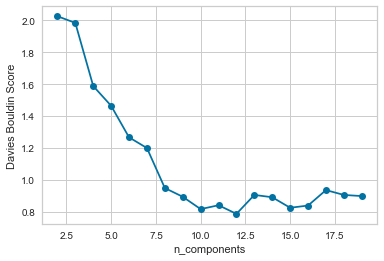

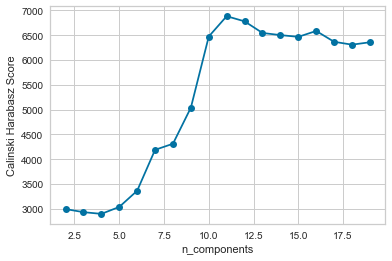

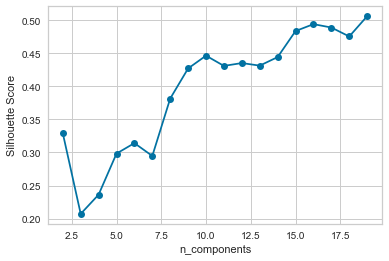

Wall time: 2min 33s


In [10]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.KMeans, (), {'n_clusters':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

We can see visually from the Davines Bouldin score that it seems that 10 and 12 clusters look like the best for KMeans clustering. The Calinski Harabasz score points to 11 or 12 as the best cluster size. Lastly, the silhouette analysis points to 10 or 12 as a reasonable cluster size. Given all of the visuals above, 10 seems to be the best. 

In [ ]:
****** K Means is missing the random forest output ***********

##### Agglormerative Clustering

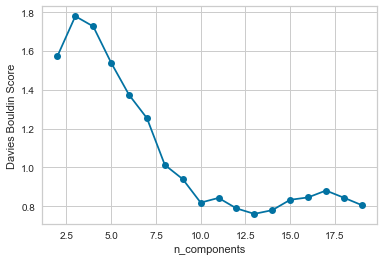

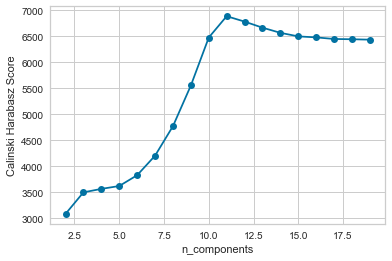

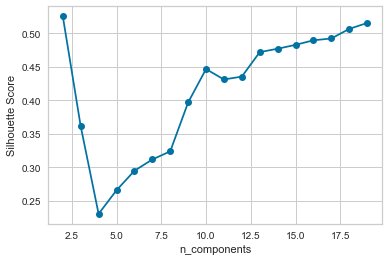

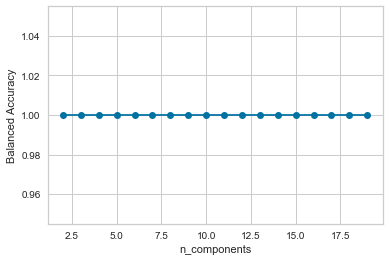

Wall time: 4min 48s


In [58]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.AgglomerativeClustering, (),
                                                   {'n_clusters':i, 'linkage':'ward'}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

Agglomerative Clustering is a hierachical technique that leverages Euclidean distance by treating each object as a single cluster and all clusters are successful merged into one large cluster. This creates a tree-based representation of objects. We can then calculate our internal and external metrics to evaluate our clusters. We can see from the Davines Bouldin score that 10 and 12 clusters lead us to the lowest score. The Calinski Harabasz score points to 11 or 12 as the ideal cluster size. The silhouette analysis sees a peak at 10 or 13 clusters. Lastly, regardless of cluster size we can see that our predictive strength is very strong and sits at 100% accuracy for any cluster size. Given all of this information, again, 10 look slike the best cluster size. 

##### Optics

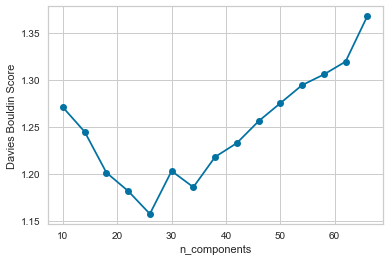

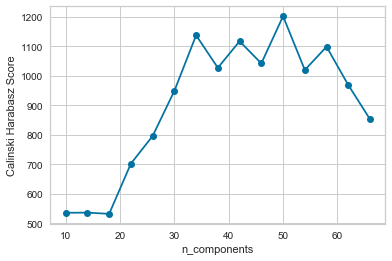

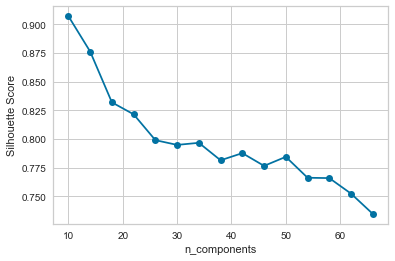

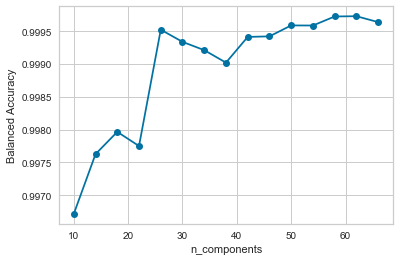

Wall time: 25min 31s


In [59]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(10,70,4)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.OPTICS, (), {'min_samples':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

Optics is a clustering algorithm that finds density based clusters in spatial data. The algorithm orders the data and then calculates distances between the data points in the order and then clusters are made. We can see from the time that this technique is far more computationally expensive. Analyzing the Davines Bouldin score you can see that 27 clusters seems to be the ideal cluster size. There are two large spikes in the Calinski Harabasz score at 32 and 50. Lastly, the silhouette score seems to provide even more conflicting information, with it's highest point sitting at 10 clusters. Prediction strength gives us a better idea here of what cluster sizes allow for better accuracy, but the reader should note that the scale on the left actually varies only slighly run to run. A cluster size of 27 again here seems to give the highest accuracy. 

###### Model Evaluation Synopsis
We can see from all the insights above that each model type and cluster size yields differing results, but our random forrest model seems to be able to decipher the clusters well regardless of cluster size. One trend that does come to light across all clusters is that 10 clusters seems to be the ideal cluster size. We will continue our analysis by focusing on other techniques leveraging the KMeans insights due to the quick processing time, and success of predictive strength and internal validation metrics. 

#### Visualize Results
**Requirements**: Use tables/visualization to discuss the found results. Explain each visualization in detail.

We will do a deeper analysis leveraging the silhouette analysis of the KMeans clustering algorithm. The function below marries the outcome of the clusters to the original dataset. We use this algorithm to provide a deeper analysis of the KMeans algorithm using 10 clusters. 

In [60]:
#Function that appends the cluster number to the dataframe
def make_df(df, lbl, names):
    #Make a data frame with the cluster number added onto it
    the_df = pd.concat([pd.DataFrame(df), pd.DataFrame(list(lbl))], axis=1)
    names.append("Clust")
    the_df.columns = names
    the_df["Clust"] = the_df["Clust"].astype(int)
    return the_df

In [61]:
%%time
kmeans = KMeans(n_clusters = 11, init = 'random', n_init = 10, n_jobs = -1).fit(x_train)

#Make a data frame with the cluster number added onto it
x_train_kmeans = make_df(x_train, kmeans.labels_, list(df_zg_hot_x.columns))

Wall time: 1.23 s


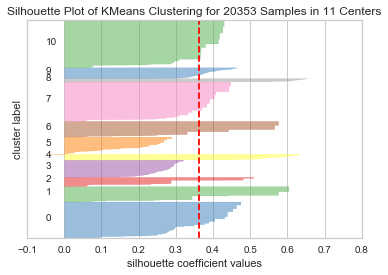

Wall time: 11.8 s


In [62]:
%%time
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(x_train)
visualizer.poof()

We can see here that our silhouette analysis gives us a coefficient analysis of 0.35. In this case the higher the silhouette coefficent, the better. You can see that the clusters vary in size due to the width of the clusters. In addition, you can see that some clusters are extremely small compared to others. 

The following code provides insight into the correlation of all the clusters, in addition to the internal cluster correlation. 

In [63]:
import seaborn as sns
def heat_map(corr):
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, linewidths = 0.5
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

##### KMean Visualization

In [64]:
#General Coorelation
x_train_kmeans.corr()

,age,gender,diabetesMed,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,Clust
age,1.000000,0.053175,-0.028833,0.029130,-0.017616,-0.032165,0.035637,0.024891,-0.153247,0.117261,-0.032699,-0.011849,0.060404,-0.033299,-0.039140,-0.017950
gender,0.053175,1.000000,-0.024545,-0.010917,0.010707,-0.000700,0.001828,-0.007048,-0.018946,0.013171,0.007163,-0.003373,-0.005347,0.007067,0.003615,0.054779
diabetesMed,-0.028833,-0.024545,1.000000,0.023135,0.021889,-0.009816,-0.019193,0.016636,0.081296,-0.060251,-0.012326,0.071735,-0.348318,0.261885,0.117574,0.261766
max_glu_serum_>200,0.029130,-0.010917,0.023135,1.000000,-0.014248,-0.519014,-0.020559,-0.016727,-0.026517,0.040288,-0.021401,0.001582,-0.026483,0.023245,0.009475,0.265155
max_glu_serum_>300,-0.017616,0.010707,0.021889,-0.014248,1.000000,-0.475019,-0.018817,-0.022903,0.006429,0.022451,-0.026284,0.019300,-0.047727,-0.001641,0.058236,0.199559
max_glu_serum_None,-0.032165,-0.000700,-0.009816,-0.519014,-0.475019,1.000000,-0.685418,0.038122,0.040698,-0.071547,0.038520,0.013634,0.007155,-0.006917,-0.021464,-0.489494
max_glu_serum_Norm,0.035637,0.001828,-0.019193,-0.020559,-0.018817,-0.685418,1.000000,-0.025104,-0.041866,0.054729,-0.019711,-0.034089,0.043683,-0.006850,-0.017770,0.350167
A1Cresult_>7,0.024891,-0.007048,0.016636,-0.016727,-0.022903,0.038122,-0.025104,1.000000,-0.059195,-0.444545,-0.046162,-0.007834,0.003378,0.001187,0.003423,-0.172695
A1Cresult_>8,-0.153247,-0.018946,0.081296,-0.026517,0.006429,0.040698,-0.041866,-0.059195,1.000000,-0.654229,-0.067935,0.027879,-0.100261,0.045470,0.067872,0.298975
A1Cresult_None,0.117261,0.013171,-0.060251,0.040288,0.022451,-0.071547,0.054729,-0.444545,-0.654229,1.000000,-0.510181,-0.014103,0.074380,-0.040115,-0.050200,0.085433


In [65]:
#All correlation with Clust sorted
x_train_kmeans.corr().sort_values(by = "Clust")["Clust"]

max_glu_serum_None   -0.489494
insulin_Down         -0.463453
A1Cresult_Norm       -0.365535
A1Cresult_>7         -0.172695
insulin_No           -0.040617
age                  -0.017950
insulin_Up            0.017768
gender                0.054779
A1Cresult_None        0.085433
max_glu_serum_>300    0.199559
diabetesMed           0.261766
max_glu_serum_>200    0.265155
A1Cresult_>8          0.298975
max_glu_serum_Norm    0.350167
insulin_Steady        0.478098
Clust                 1.000000
Name: Clust, dtype: float64

You can see the results above showcase the correlation values in comparison to the cluster outcome. The values more negatively correlated with the cluster result are max_glu_serum_None, insulin_Down, and the A1Cresult_norm. The values most positively correlated with cluster result are insulin_Steady, max_glu_serum_Norm, and A1Cresult>8. What we can glean from these top positively and negatively correlated values is an idea of what our clusters entail. It seems that the negatively correlated values relate to medical reasoning for little to no diabetes, whereas the positively correlated values relate to diabetes. 

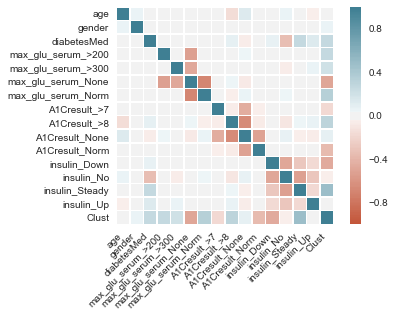

In [66]:
#Coorelation by Cluster
heat_map(x_train_kmeans.corr())

###### In-cluster coorelation

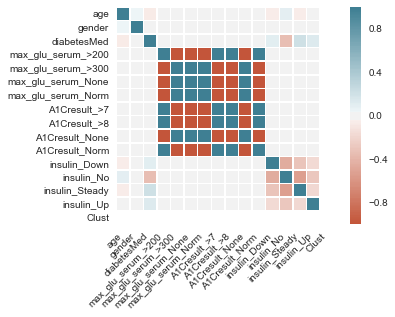

In [67]:
#0 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 0].corr())

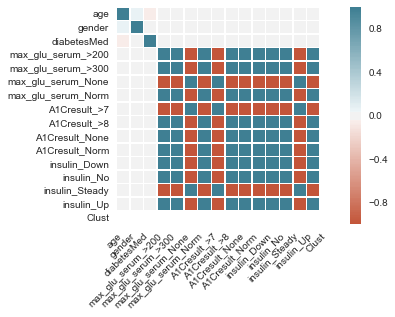

In [68]:
#1 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 1].corr())

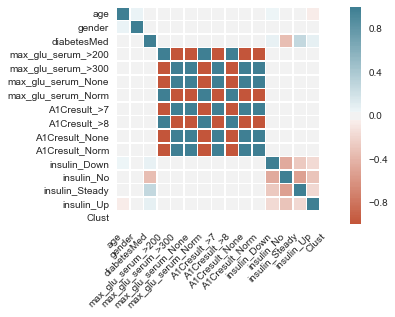

In [69]:
#2 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 2].corr())

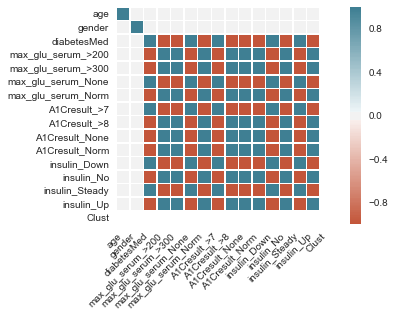

In [70]:
#3 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 3].corr())

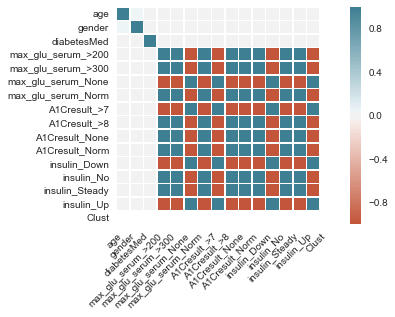

In [71]:
#4 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 4].corr())

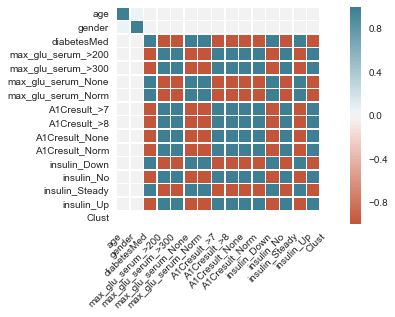

In [72]:
#5 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 5].corr())

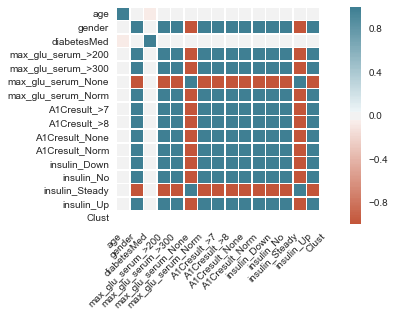

In [73]:
#6 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 6].corr())

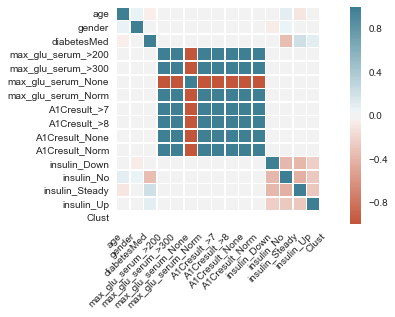

In [74]:
#7 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 7].corr())

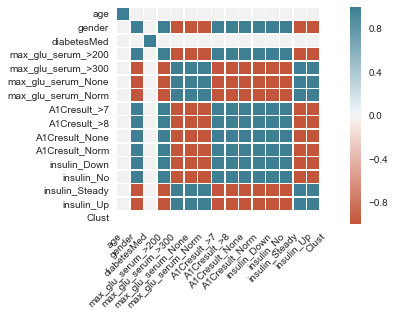

In [75]:
#8 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 8].corr())

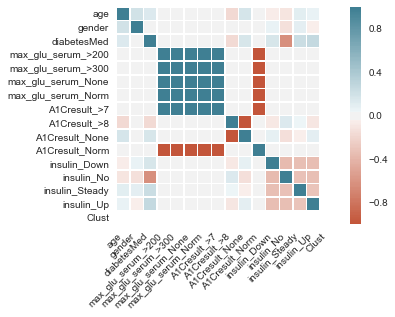

In [76]:
#9 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 9].corr())

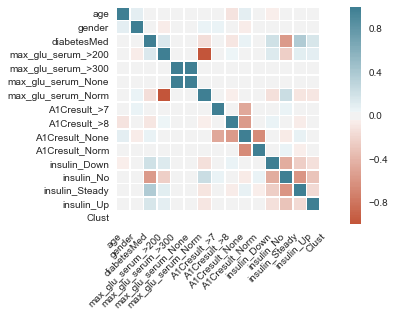

In [77]:
#10 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 10].corr())

#### Summarize the Ramifications 
**Requirements**: Describe your results. What findings are the most interesting and why? 

Leveraging the insights from the correlation analysis above, if we continue to examine these correlations, I think we can align these clusters to our relative hypothesis which was that the clusters would showcase the different types of diabetes, and because of the high number of clusters, we also believe the model is picking up on the severity of the diabetes (no diabetes to extreme diabetes). The insights these clusters provide could positively influence the predictive power for the original purpose of the dataset which was to predict whether or not a patient would be readmitted into the hospital. This clustering could help because it could identify the most at risk patients with extreme and uncontrolled diabetes. Below we will continue our clustering analysis by leveraging different variables in order to see if we can identify smaller clusters. 

#### Simpler Clusteirng Analysis

We wanted to make a simpler model based on the correlation heatmaps from the more complex analysis. We saw some multi-collinearity between variables, which can sometimes impact the effectiveness of the clustering. Below we got through the same steps: data preperation, model building, hyper-parameter tuning, evaluation, and then visualization. For this analysis we will be building a KNN with three variables: age, medication_count, and num_procedures. 

###### Data Preperation

In [9]:
#directory = '/Users/samanthasprague/Downloads/'
#df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
directory = 'C:/githubrepo/7331_Project/data/'
df_clean = pd.read_csv(directory + 'Diabetic_Cleaned.csv')

df_clean.replace('?', np.nan, inplace=True)
df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10
df_clean["age"] = df_clean["age"].astype(int)
NumFeatures=["age","medication_count","num_lab_procedures"]
df_clean_wDummies = df_clean[NumFeatures]
subsam_df_clean_wDummies=df_clean_wDummies.sample(frac=0.1)
df=subsam_df_clean_wDummies
df_norm_MinMax = (df - df.min()) / (df.max() - df.min())
df_norm_MinMax.head()

,age,medication_count,num_lab_procedures
11830,0.777778,0.333333,0.445378
93264,0.888889,0.333333,0.159664
1931,0.777778,0.166667,0.369748
2784,0.666667,0.166667,0.613445
54079,0.666667,0.666667,0.319328


In [10]:
X=df_norm_MinMax

###### Model Building and Evaluation

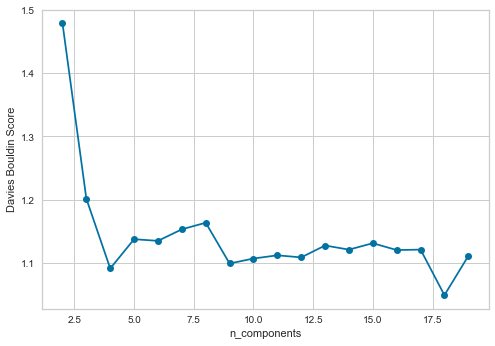

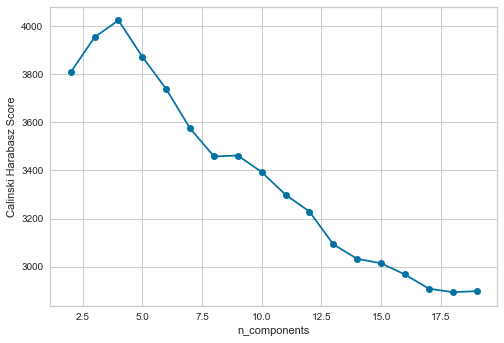

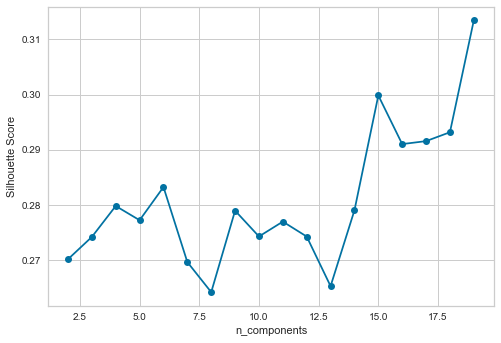

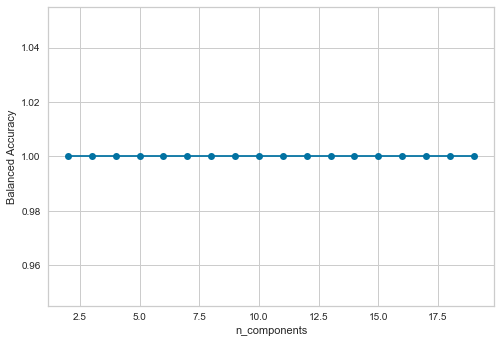

Wall time: 47.5 s


In [12]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS', 'BA'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(X, cluster.KMeans, (), {'n_clusters':i}, True)
#x_train = data_set
#{'n_clusters':i} parameters sent into function
#True == makes silouette run, silouette takes longer to run
#make plot, False
    
#Plots the metrics
plot_metrics(metric_df, size_rng)

We can see from the Davines Bouldin score that 3 or 4 clusters seems to be the ideal cluster size. The Calinski Harabasz score also gives the same information, that 3 or 4 cluster seem to be the ideal cluster size. The silhouette score provides an interesting insight, where 3 or 4 does give some depth, but 15 in this case seems to be most ideal. Looking at the balance accuracy from the random forest, regardless of cluster size we get a perfect accuracy. 

###### Visualization

Due to the insights above, we will be further evaluating the 3 clusters KMeans model through a specific sihouette analysis.

In [13]:
cls = KMeans(n_clusters=3, init='k-means++',random_state=1)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

In [14]:
X2 = np.column_stack((X,pd.get_dummies(newfeature)))

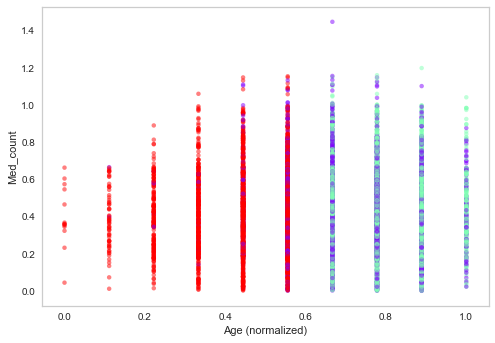

In [15]:
#run fast 
plt.figure()
#plt.subplot(1,2,1)
X2=X2
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0,alpha=0.5)
plt.xlabel('Age (normalized)'), plt.ylabel('Med_count')
plt.grid()

There seems to be some basic clusters forming: red seems to point toward type 1 diabetes (due to age), and green/purple seemed to be mixed by medication count. Interesting patterns for a 2D plot. Let's see if we get better separation by clustering in a 3D plot. 

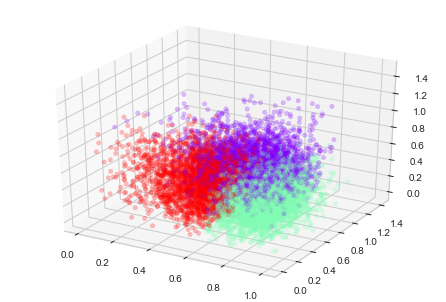

In [17]:
#3D plot
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2,X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow,alpha=0.25)
pyplot.show()

Wow! What great separation of clusters we see in the 3D plot. It is interesting to see how the clusters polarize along the gradient of each variable.

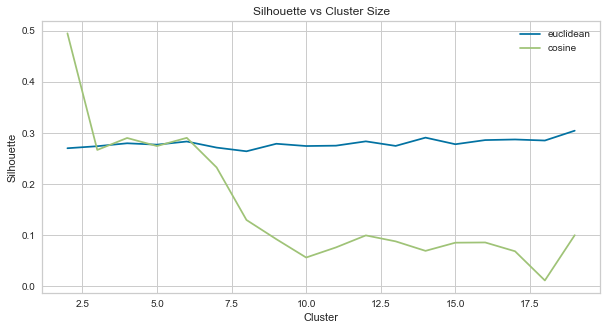

Wall time: 1min 5s


In [20]:
%%time
X=df_norm_MinMax
data=df_norm_MinMax

# Silhouette vs Cluster Size
# do it for the k-means

seuclid = []
scosine = []
k = range(2,20)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

Above we can see the silhouette analysis with the two different kinds of distance calculation. We can see that the highest silhouette score for both distnaces is roughly at 0.3.  We will dive further into this below. 

###### Silhouette analysis
The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.5753582609348815
For n_clusters = 3 The average silhouette_score is : 0.8045896262155361
For n_clusters = 4 The average silhouette_score is : 0.6183513176156741
For n_clusters = 5 The average silhouette_score is : 0.4672516839152299
For n_clusters = 6 The average silhouette_score is : 0.3438691144513975


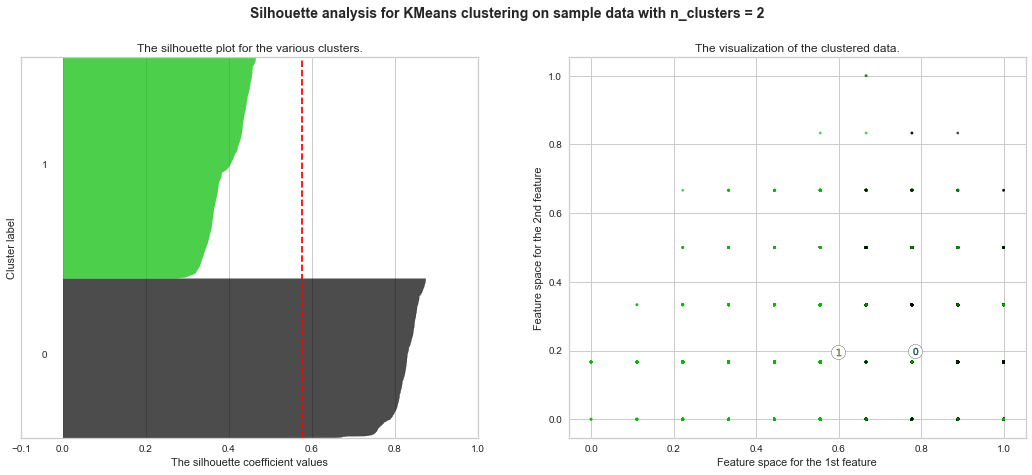

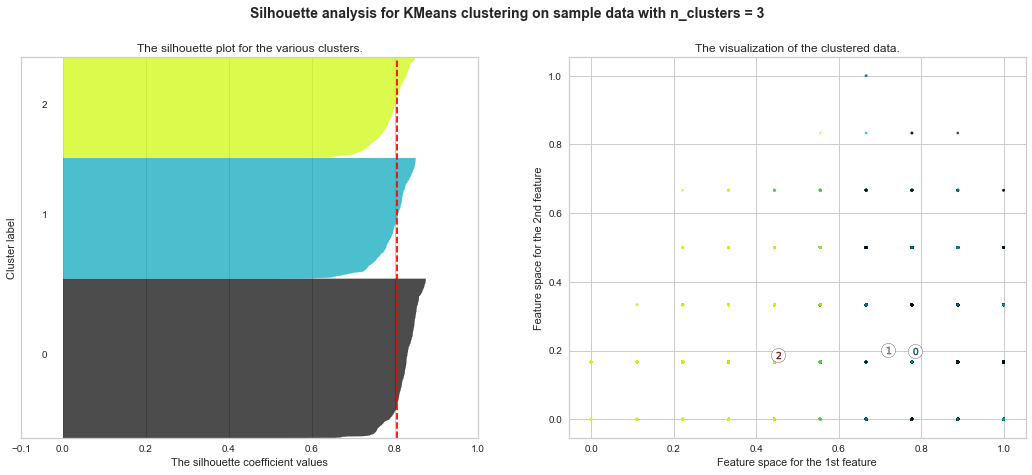

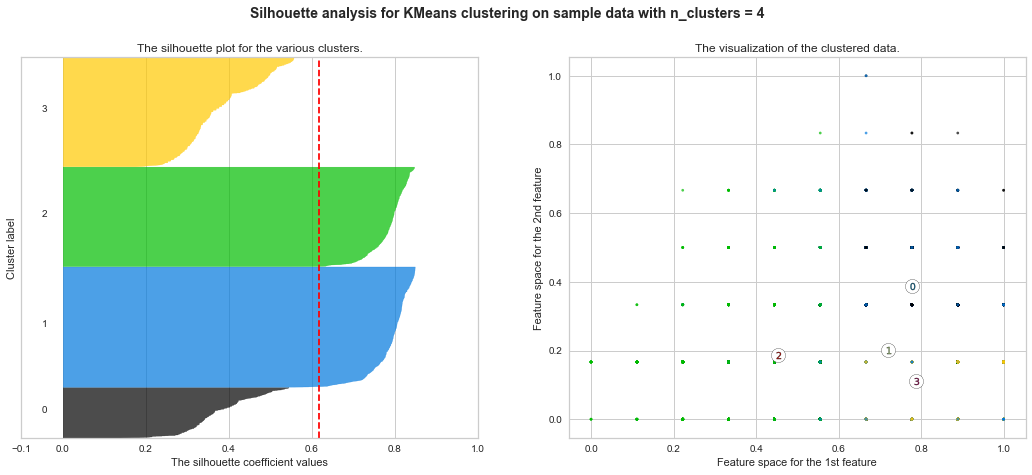

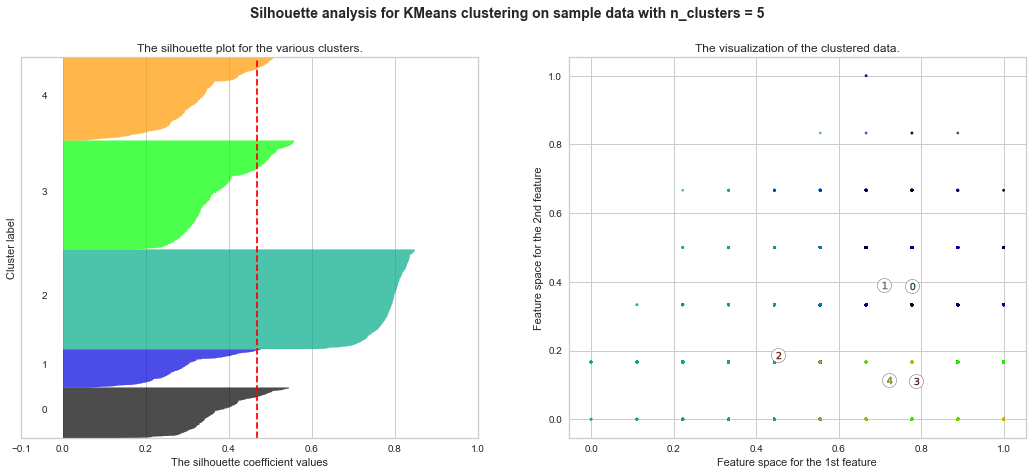

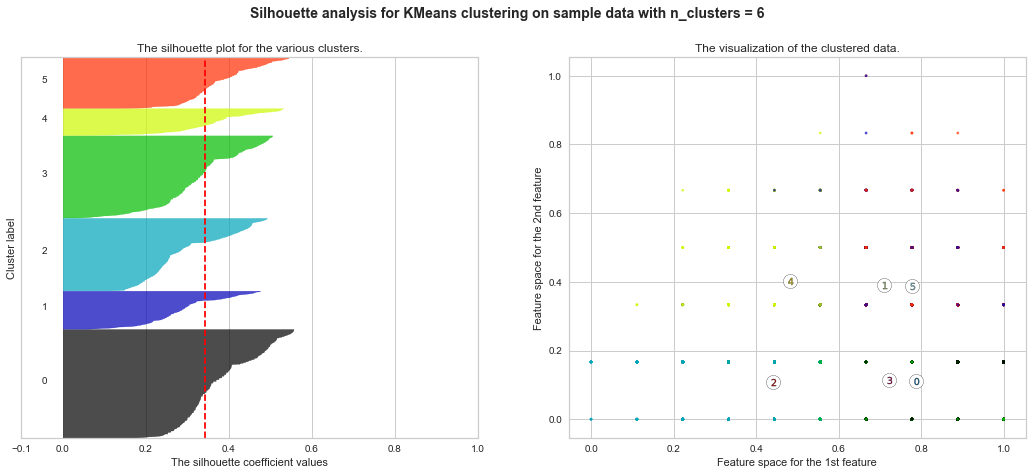

Wall time: 21.1 s


In [22]:
%%time
print(__doc__)

# y_lower = 10?
X=X2
y=newfeature
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

When we compare the silhouette analysis coefficent values of all the differing cluster sizes of the KMeans clustering model, we can see that we get the best silouette score for 3 variables at roughly 0.8. The clusters also seem to be of the same size. Below we will look into the Pearson correlation of the clusters to the specific variables. 

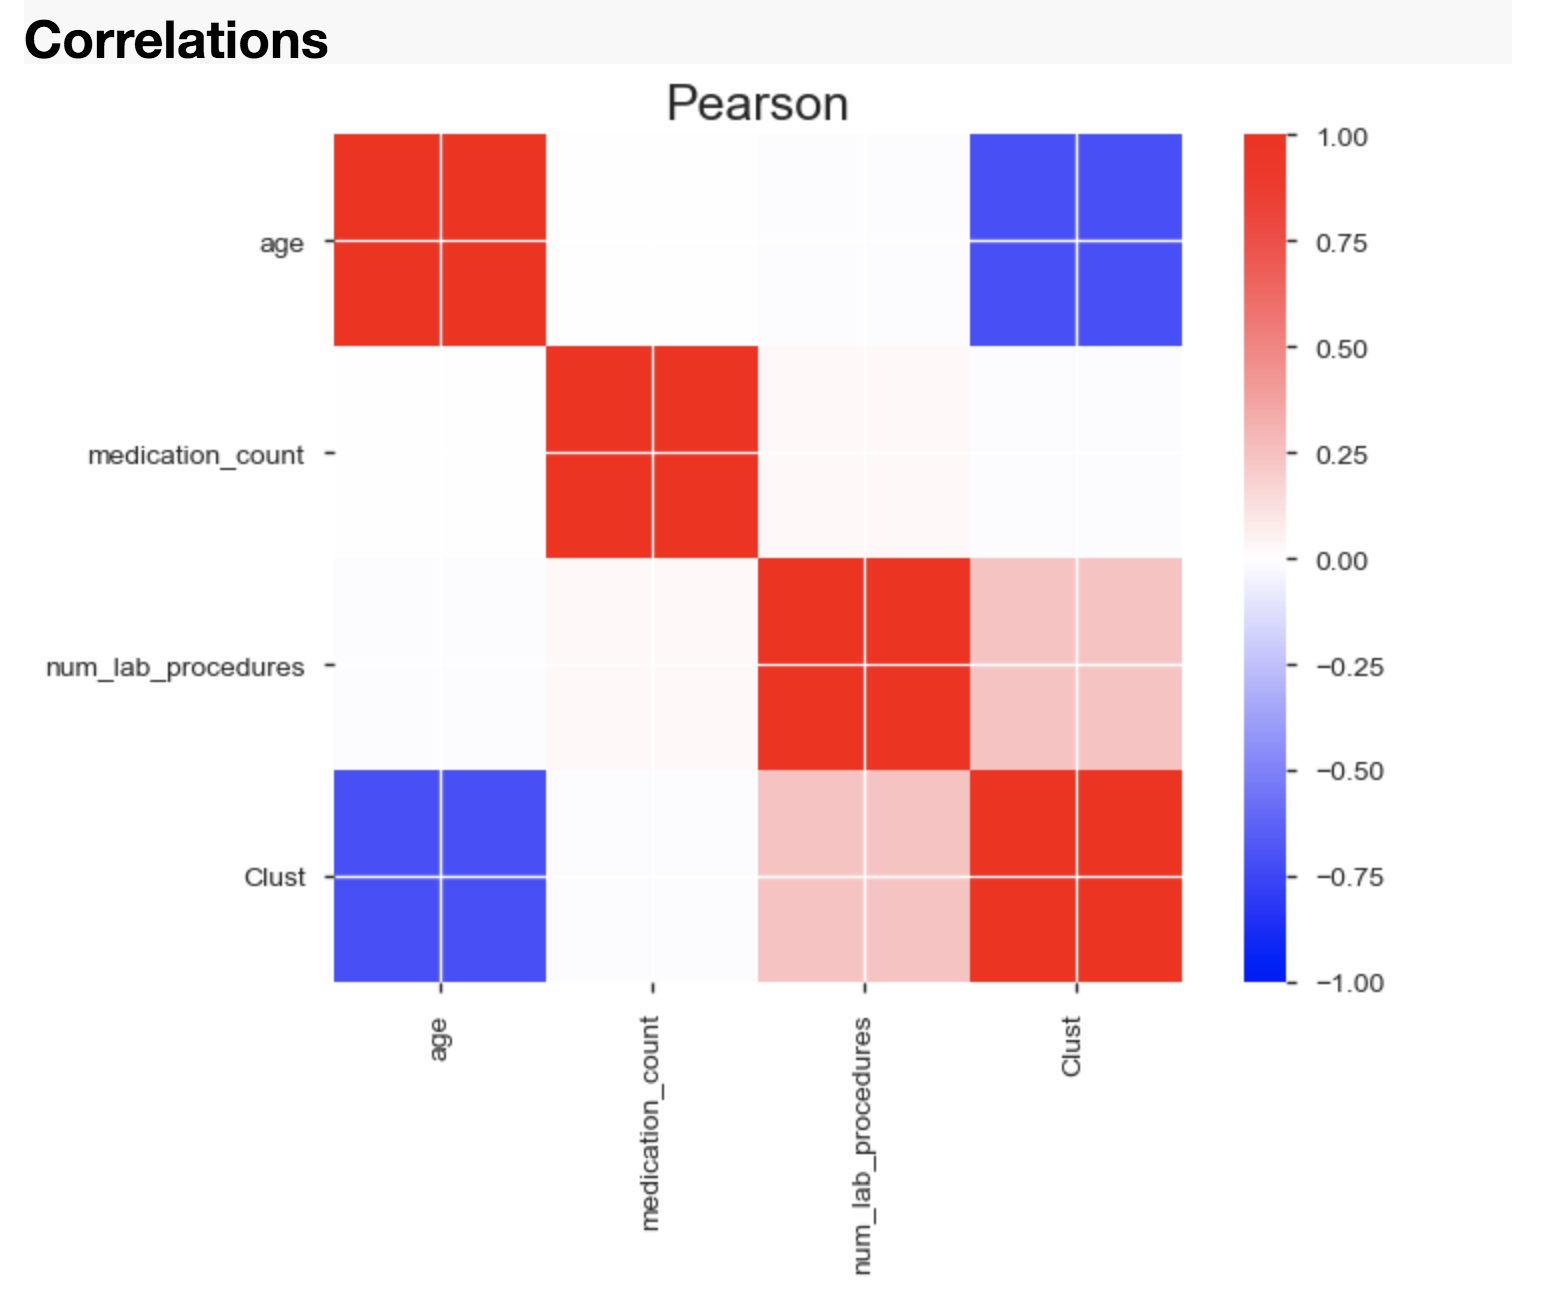

In [2]:
from IPython.display import Image
Image(filename="/Users/samanthasprague/Desktop/lab3.4.png")

The analysis above showcase that there is a strong correlation of clusters to both age and number of lab procedures. This is a good sign as that is very influencial of the clusters. Because of these findings, we want to simplify the model even further to only two variables: age and medication count. You can see the analysis below. 

##### Simplier KMeans

We will be providing insights into all stages of the analysis: data preperation, model building, model tuning, evaluation, and visualization. 

In [23]:
#directory = '/Users/samanthasprague/Downloads/'
#df = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
directory = 'C:/githubrepo/7331_Project/data/'
df_clean = pd.read_csv(directory + 'Diabetic_Cleaned.csv')

df_clean.replace('?', np.nan, inplace=True)
df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10
df_clean["age"] = df_clean["age"].astype(int)
NumFeatures=["age","medication_count","num_lab_procedures"]
df_clean_wDummies = df_clean[NumFeatures]
subsam_df_clean_wDummies=df_clean_wDummies.sample(frac=0.1)
df=subsam_df_clean_wDummies
df_norm_MinMax = (df - df.min()) / (df.max() - df.min())
df_norm_MinMax.head()

,age,medication_count,num_lab_procedures
42285,0.777778,0.2,0.588235
24134,0.888889,0.0,0.176471
19343,0.777778,0.2,0.252101
89666,0.888889,0.6,0.243697
33685,0.777778,0.6,0.344538


In [24]:
NumFeatures=["age","medication_count"] #"gender",
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1) 

In [25]:
df_clean_wDummies = df_clean[NumFeatures]
subsam_df_clean_wDummies=df_clean_wDummies.sample(frac=0.1)

In [26]:
df=subsam_df_clean_wDummies
# 1. Min-max scaling
df_norm_MinMax = (df - df.min()) / (df.max() - df.min())

#normal scaling (0 mean 1 sd scaling)
df_norm_musigma = (df - df.mean()) / (df.std())

df_norm_medsigma = (df - df.median()) / (df.std())

In [31]:
#run fast 
X=df_norm_MinMax

cls = KMeans(n_clusters=3, init='k-means++',random_state=1)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

In [32]:
X2 = np.column_stack((X,pd.get_dummies(newfeature)))

In [33]:
X2

array([[0.66666667, 0.16666667, 1.        , 0.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.        , 1.        ],
       [0.77777778, 0.16666667, 1.        , 0.        , 0.        ],
       ...,
       [0.77777778, 0.16666667, 1.        , 0.        , 0.        ],
       [0.66666667, 0.        , 1.        , 0.        , 0.        ],
       [0.44444444, 0.16666667, 0.        , 0.        , 1.        ]])

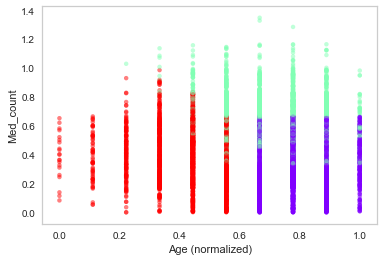

In [34]:
#run fast 
plt.figure()
#plt.subplot(1,2,1)
X2=X2
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0,alpha=0.5)
plt.xlabel('Age (normalized)'), plt.ylabel('Med_count')
plt.grid()

We can see great separation of the KMeans model with two variables within the 2D plot. 

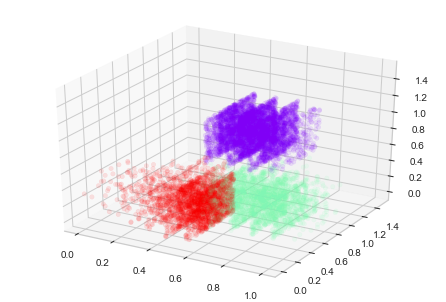

In [36]:
#3D plot
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2,X2[:, 2]+np.random.random(X2[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow,alpha=0.1)
pyplot.show()

There seems to be even more separation within the 3D plot. 

Wall time: 1.67 s


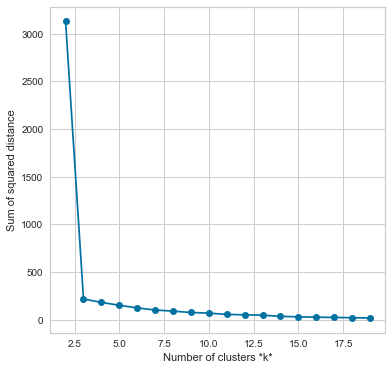

In [38]:
%%time
#Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(2, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X2)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

It is clear here with the sum of squared distance that the best cluster size for the KMeans with two variables is 3. 

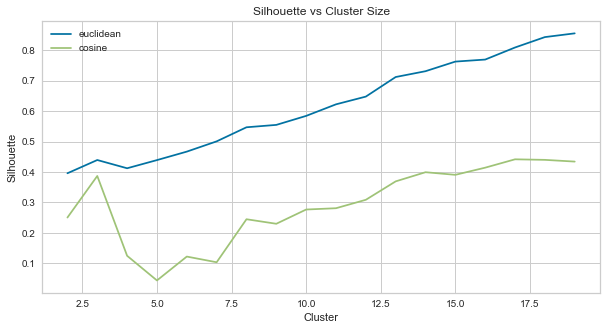

Wall time: 1min 2s


In [40]:
%%time
#run for 1 min
X=df_norm_MinMax
data=df_norm_MinMax

# Silhouette vs Cluster Size
# do it for the k-means

seuclid = []
scosine = []
k = range(2,20)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

The graph above also continue to support the idea that 3 clusters is the best for the 2 variable KMeans. 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.6455189445972845
For n_clusters = 3 The average silhouette_score is : 0.8807365922896506
For n_clusters = 4 The average silhouette_score is : 0.773551474089957
For n_clusters = 5 The average silhouette_score is : 0.5688210450868143
For n_clusters = 6 The average silhouette_score is : 0.4689636287467785


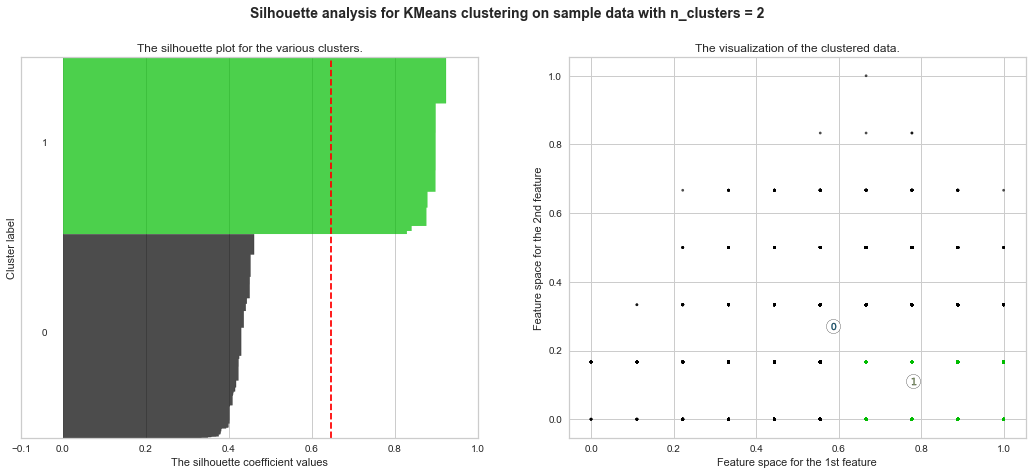

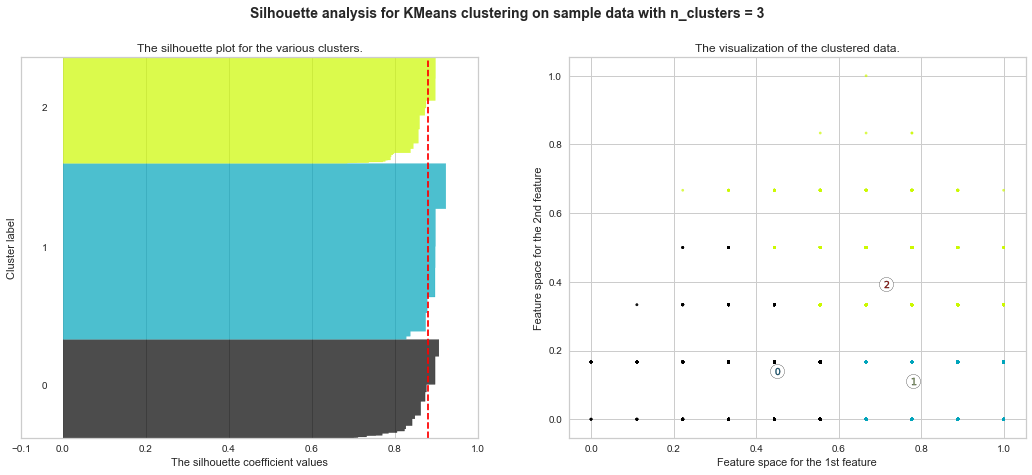

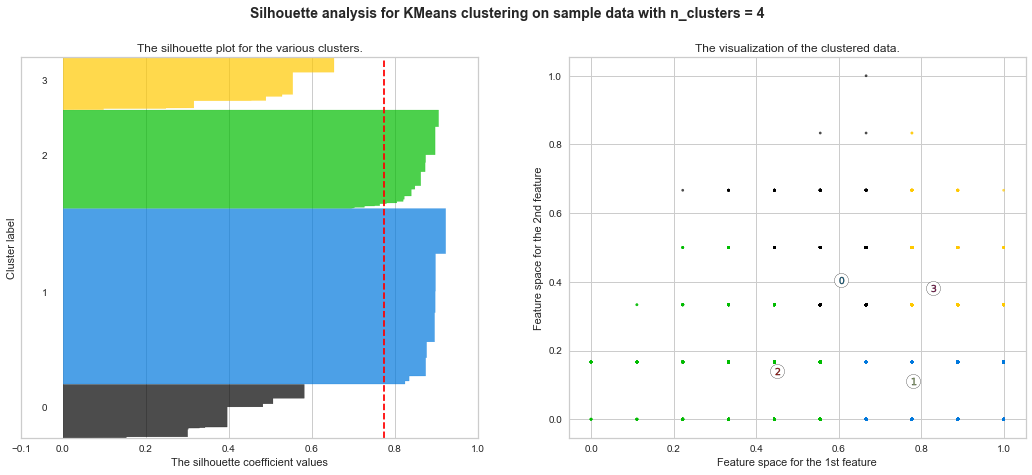

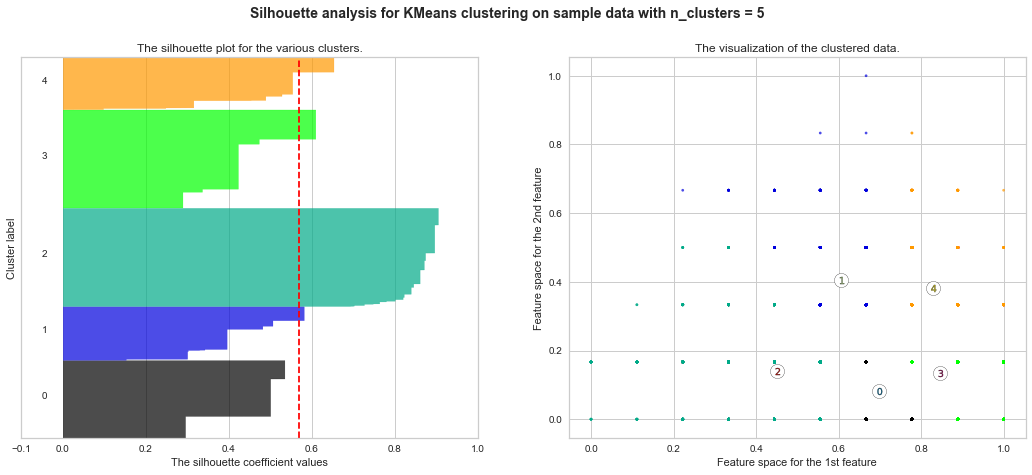

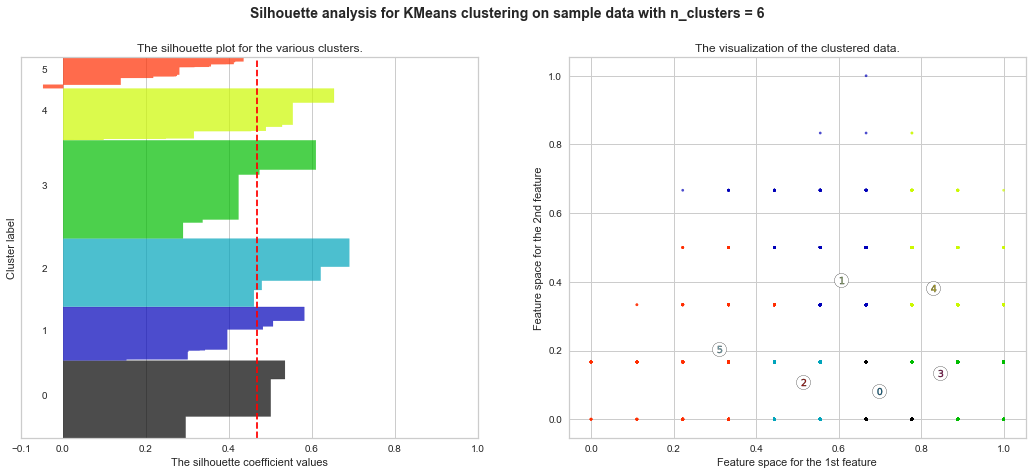

Wall time: 21 s


In [42]:
%%time
print(__doc__)

# y_lower = 10?
X=X2
y=newfeature
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The deep insight provided by the silhouette analysis further validates that 3 clusters with 2 variables provides the most value with a coefficient of 0.88. This provides justification that this simple model can give the best results for clustering our diabetes dataset. 

#### Summarize the Ramifications 
**Requirements**: Describe your results. What findings are the most interesting and why? 

All in all, the insight provided from leveraging smaller clusters and minimal columns showcase an example of Ockham's razor -- the simpler the model, the better the results. Here we can see that the simpler model aligns to our current understanding and original hypothesis for this report, that we could properly cluster diabetes patients based on both their type of diabetes, but also the severity. You can see from the last model that the cluster align to: 1. no/little diabetes, 2. type 1 diabetes, and 3. type 2 diabetes. These natural clusters are given by age and the number of medications and/or procedures. Furthermore, if we wanted to align people to specific diabetes type AND severity, we could leverage clusters found at the beginning of the report. In conclusion, it is clear from this analysis that there are high correlations of patient type that align to diabetes type and severity. This knowledge could be incredibly helping in not only predicting if a patient will need to be readmitted, but can indicate the type of care that a patient will need. More insight into the type of uses for these models and insights is provided below in the deployment section. 

<a id="Deployment"></a>
## Deployment 

**Requirements**: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

As you have now seen from the analysis thus far, there are many relationships within the dataset that are not obvious through traditional EDA techniques. By performing a cluster analysis, irrespective of any target variable, you can uncover hidden relationships and groupings that would otherwise not be seen. 

Using predictive strength on all of the clustering models we created, we saw perfect (or nearly perfect) performance. This validates the success of our clustering techniques given the distinct groupings within our original dataset. 

One use for the insights provided through our cluster analysis may be to categorize and separate the data prior to any supervised modeling techniques are applied. By separating the particular groups prior to supervised modeling, you will have narrowed down your scope of prediction, and allowed the model to focus on the patterns that matter, rather than have it get distracted by the patterns apparently through the groupings. In this case, instead of predicting just readmittance through the target variable, we may be able to predict readmittance for a specific type of diabetes. By doing so, patient treatment would theoretically increase as the doctors are able to focus on a specific type of diabetes and the known issues with that diagnosis. 

Another use of this cluster analysis could be to apply treatments differently based on the subgroups seen above. In particular, the first set of modeling techniques we provided aligned themselves nicely to 9-11 clusters. One thought would be to examine the medicine and medical treaments used on these indivduals in order to provide better care. It could be a method to alert doctors to a specific treament plan for better success rates. 

In order to deploy our model, we would need to integrate with the current medical system in which doctors are entering patient data. By integrating our solution with the current system they leverage, we could build a suite of differing models that predict information (in this case, diabetes type or treatment options) and can alert doctors while assessing and developing a treatment plan for the patient. 

As always, the more data collected, the greater the impact and predictive power our models will have. We suggest ensuring patient data: age, height, weight, etc. are all updated, as well as detailed descriptions of the symptoms patients are having. By providing insight to symptoms, we may better be able to predict cause. 

Our model would need to be updated regularly to ensure that patient data is properly updated through each stage of the lifecycle. In addition, as time continues, the amount of data we have will be updated and be able to provide greater insight and newer trends that manifest as technological advances in medicine continue to transpire. 

<a id="Exceptional Work"></a>
## Exceptional Work

For our exceptional work portion, we wanted to supplement all the work we did for unsupervised clustering detection with Apriori rules. The thought process behind this is that we could glean insight into some of the patterns that the clustering models showcased. We found great success that these rules aligned to the clusters created above. Scroll for more insights. 

In [43]:
#df_mlt = pd.read_csv('/Users/mtran/Documents/SMUDataSciences/2019-Summer/Diabetic_Cleaned.csv')
#print("Finished loading data")
directory = 'C:/githubrepo/7331_Project/data/'
df_mlt = pd.read_csv(directory + 'Diabetic_Cleaned.csv')

In [44]:
#make dataframes for each column
ordinal = ["age"]
categorical = ["gender", "diabetesMed"]
medicines = ["max_glu_serum", "A1Cresult","insulin"]

In [45]:
df_mlt_ordinal = df_mlt[ordinal]
df_mlt_categorical = df_mlt[categorical]
df_mlt_medicines = df_mlt[medicines]

In [46]:
#Make age ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_mlt_ordinal.loc[df_mlt_ordinal['age'] == val, 'age'] = i
df_mlt_ordinal["age"] = df_mlt_ordinal["age"].astype(object)

In [47]:
#Creating dataframe
df_mlt_med_x = pd.concat([pd.get_dummies(df_mlt_ordinal), pd.get_dummies(df_mlt_categorical), pd.get_dummies(df_mlt_medicines)], axis = 1)
print("Done")

Done


In [48]:
df_mlt_med_x

,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
5,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
7,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0


In [49]:
%%time
support = 0.2
confidence = 0.5
ant_len = 3

frequent_itemsets = apriori(df_mlt_med_x, min_support=support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
print("Number of Rules:", len(rules[(rules['antecedent_len'] >= ant_len)]))

Number of Rules: 13
Wall time: 94.7 ms


In [50]:
pd.set_option('display.max_colwidth', -1)
rules = rules.drop(['consequent support', 'antecedent support', 'conviction', 'leverage'], axis=1)
rules[(rules['antecedent_len'] >= ant_len)]

,antecedents,consequents,support,confidence,lift,antecedent_len
79,"(max_glu_serum_None, gender_Female, A1Cresult_None)",(diabetesMed_Yes),0.295010,0.694825,0.973036,3
80,"(max_glu_serum_None, gender_Female, diabetesMed_Yes)",(A1Cresult_None),0.295010,0.819199,0.983700,3
81,"(max_glu_serum_None, A1Cresult_None, diabetesMed_Yes)",(gender_Female),0.295010,0.537759,1.000266,3
82,"(gender_Female, A1Cresult_None, diabetesMed_Yes)",(max_glu_serum_None),0.295010,0.937075,0.989031,3
88,"(max_glu_serum_None, gender_Female, insulin_No)",(A1Cresult_None),0.204558,0.860349,1.033113,3
89,"(max_glu_serum_None, A1Cresult_None, insulin_No)",(gender_Female),0.204558,0.538659,1.001940,3
90,"(gender_Female, A1Cresult_None, insulin_No)",(max_glu_serum_None),0.204558,0.946744,0.999236,3
93,"(gender_Male, max_glu_serum_None, A1Cresult_None)",(diabetesMed_Yes),0.253582,0.707169,0.990322,3
94,"(gender_Male, max_glu_serum_None, diabetesMed_Yes)",(A1Cresult_None),0.253582,0.803600,0.964968,3
95,"(gender_Male, A1Cresult_None, diabetesMed_Yes)",(max_glu_serum_None),0.253582,0.937684,0.989674,3


Using a support of greater than or equal to 0.2, and a confidence of at least 0.5, with an antecedent length of at least 3, we get a list of 15 rules. Removing duplication from the rules, there are 3 trends that emerge. Rules 79-82 showcase a cluster of females with what appears to be gesitational diabetes. Rules 88-90 are female and no diabetes, 93-95 align to males with type 2 diabetes, and lastly 100-102 indicate regardless of gender, no diabetes. This insight is incredibly useful when aligning the cluster found above to these rules. It is very likely that these clusters above have picked up on these trends very clearly outlined in the Apriori rules. 

<a id="References"></a>
## References

[1] World Health Organization. 10 Facts on Diabetes. https://www.who.int/features/factfiles/diabetes/en/

[2] Robert TIBSHIRANI and Guenther WALTHER. Standford. Publication. http://statweb.stanford.edu/~gwalther/predictionstrength.pdf